## Import required libraries

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## Load the Data

In [189]:
df = pd.read_csv("fact_charging_sessions.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.head()

,Session ID,User ID,Vehicle_Variant_ID,Station_Variant_ID,Date,TimeOfDay_ID,Charging Duration (hours),Energy Consumed (kWh),Charging Rate (kW),Charging Cost (USD)
0,S1,User_1,V27,S784,2024-01-01,1,0.650,60.712,36.389,13.09
1,S2,User_2,V86,S887,2024-01-01,2,2.017,12.339,30.678,21.13
2,S3,User_3,V51,S243,2024-01-01,2,2.800,19.129,27.514,35.67
3,S4,User_4,V70,S622,2024-01-01,1,3.700,79.458,32.883,13.04
4,S5,User_5,V70,S36,2024-01-01,2,1.767,19.629,10.216,10.16


##  Aggregate monthly data

In [190]:
monthly_data = df.groupby(df['Date'].dt.to_period('M')).agg({
    'Energy Consumed (kWh)': 'sum',
    'Charging Cost (USD)': 'sum'
}).reset_index()

monthly_data['Date'] = monthly_data['Date'].dt.to_timestamp()
monthly_data['Month_Index'] = np.arange(len(monthly_data))

print(monthly_data)


        Date  Energy Consumed (kWh)  Charging Cost (USD)  Month_Index
0 2024-01-01              32909.886             16813.49            0
1 2024-02-01              24894.558             12954.21            1
2 2024-03-01             108357.787             59929.47            2
3 2024-04-01             107058.088             59442.16            3
4 2024-05-01             107650.367             59020.60            4
5 2024-06-01             108910.683             61009.20            5
6 2024-07-01             110242.713             59860.00            6
7 2024-08-01             105505.757             59068.86            7


## Model Training

In [191]:
## Remove early months due to abnormal usage patterns (data ramp-up / cold start effect)
stable_data = monthly_data.iloc[2:].copy()

X = stable_data[['Month_Index']]
y_energy = stable_data['Energy Consumed (kWh)']
y_revenue = stable_data['Charging Cost (USD)']

# Train Linear Regression models
energy_model = LinearRegression()
energy_model.fit(X, y_energy)

revenue_model = LinearRegression()
revenue_model.fit(X, y_revenue)

LinearRegression()

## Model Prediction for next 3 months

In [192]:
future_months = 3
last_index = stable_data['Month_Index'].iloc[-1]
future_index = np.array(range(last_index + 1, last_index + future_months + 1)).reshape(-1,1)

future_index_df = pd.DataFrame(future_index, columns=['Month_Index'])

energy_forecast = energy_model.predict(future_index_df)
revenue_forecast = revenue_model.predict(future_index_df)

future_dates = pd.date_range(
    start=stable_data['Date'].max() + pd.offsets.MonthBegin(1),
    periods=future_months,
    freq='MS')

In [193]:
forecast_df = pd.DataFrame({
    'Month': future_dates,
    'Forecasted Energy Consumed (kWh)': energy_forecast,
    'Forecasted Revenue (USD)': revenue_forecast})

print("Forecasted Next 3 Months:\n", forecast_df)

Forecasted Next 3 Months:
        Month  Forecasted Energy Consumed (kWh)  Forecasted Revenue (USD)
0 2024-09-01                     107609.636600              59615.622000
1 2024-10-01                     107511.180629              59585.309714
2 2024-11-01                     107412.724657              59554.997429


## Visualize Energy & Revenue forecast plotting

In [194]:
#Combine historical + forecast for plotting

plot_df = pd.concat([
    monthly_data[['Date','Energy Consumed (kWh)','Charging Cost (USD)']].rename(columns={'Date':'Month'}),
    forecast_df.rename(columns={
        'Forecasted Energy Consumed (kWh)':'Energy Consumed (kWh)',
        'Forecasted Revenue (USD)':'Charging Cost (USD)'})], ignore_index=True)


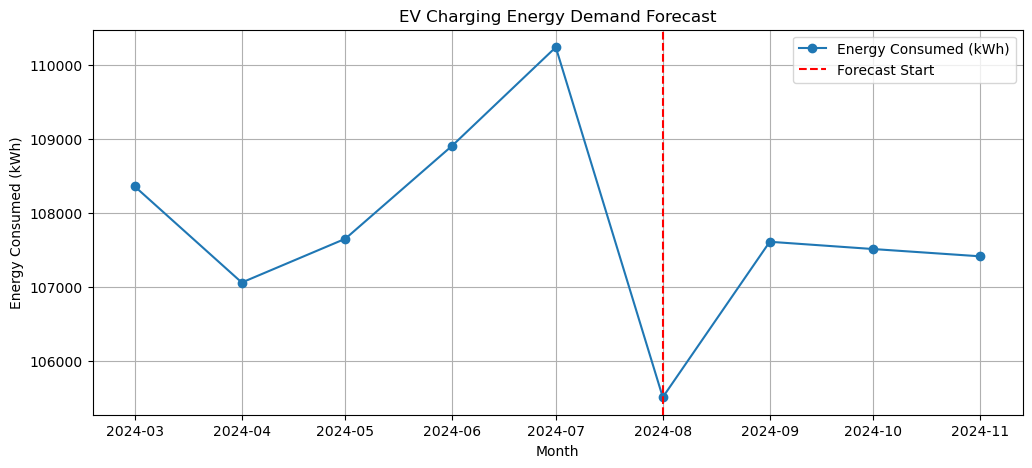

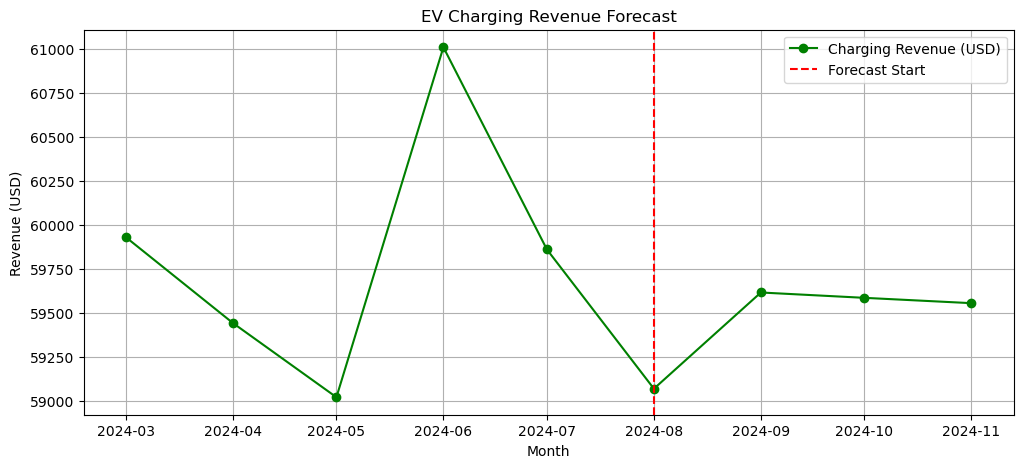

In [195]:
plot_start_date = stable_data['Date'].min()
plot_df_filtered = plot_df[plot_df['Month'] >= plot_start_date]

# Energy demand forecast plot
plt.figure(figsize=(12,5))
plt.plot(plot_df_filtered['Month'], plot_df_filtered['Energy Consumed (kWh)'], marker='o', label='Energy Consumed (kWh)')
plt.axvline(x=stable_data['Date'].max(), color='red', linestyle='--', label='Forecast Start')
plt.title("EV Charging Energy Demand Forecast")
plt.xlabel("Month")
plt.ylabel("Energy Consumed (kWh)")
plt.grid(True)
plt.legend()
plt.show()

#Revenue forecast plot
plt.figure(figsize=(12,5))
plt.plot(plot_df_filtered['Month'], plot_df_filtered['Charging Cost (USD)'], marker='o', color='green', label='Charging Revenue (USD)')
plt.axvline(x=stable_data['Date'].max(), color='red', linestyle='--', label='Forecast Start')
plt.title("EV Charging Revenue Forecast")
plt.xlabel("Month")
plt.ylabel("Revenue (USD)")
plt.grid(True)
plt.legend()
plt.show()


## Evaluate model performance (MAE)

In [196]:
#Evaluste MAE
energy_mae = mean_absolute_error(stable_data['Energy Consumed (kWh)'], energy_model.predict(stable_data[['Month_Index']]))
revenue_mae = mean_absolute_error(stable_data['Charging Cost (USD)'], revenue_model.predict(stable_data[['Month_Index']]))

print(f"Energy Demand MAE: {energy_mae:.2f} kWh")
print(f"Revenue MAE: {revenue_mae:.2f} USD")

Energy Demand MAE: 1199.75 kWh
Revenue MAE: 539.46 USD


In [197]:
forecast_df.to_csv("ev_forecast_next_3_months.csv", index=False)
monthly_data.to_csv("ev_monthly_summary.csv", index=False)

In [198]:
forecast_df

,Month,Forecasted Energy Consumed (kWh),Forecasted Revenue (USD)
0,2024-09-01,107609.636600,59615.622000
1,2024-10-01,107511.180629,59585.309714
2,2024-11-01,107412.724657,59554.997429
